# PERSON D — MODELLING STEP (XGBoost)

## 1. Load the data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_csv("../data/features.csv")
y = pd.read_csv("../data/target.csv").squeeze()


In [2]:
# LEAKAGE PREVENTION 
# 'days_since_last_purchase' is dropped to force the model to learn from other signals.
features_to_drop = ['days_since_last_purchase']
X = X.drop(columns=[col for col in features_to_drop if col in X.columns])
print(f"DROPPED LEAKAGE FEATURES: {features_to_drop}")

# Validation Check
print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
X.head()

DROPPED LEAKAGE FEATURES: ['days_since_last_purchase']
Features Shape: (1200, 8)
Target Shape: (1200,)


,age,income,total_orders,avg_order_value,estimated_spend,spend_ratio,sentiment_score,risk_score
0,58,74592,22,133.88,2945.36,0.039486,1,1
1,61,131482,42,161.12,6767.04,0.051467,2,0
2,50,138907,50,219.59,10979.50,0.079042,2,0
3,44,64446,22,258.07,5677.54,0.088098,0,2
4,62,115392,32,204.42,6541.44,0.056689,0,2


## 2. Train/Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train Size: {X_train.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")

Train Size: 960
Test Size: 240


## 3. Train XGBoost

In [4]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 4. Evaluatiom

In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob):.4f}")


Accuracy: 0.9458
F1-Score: 0.9266
ROC-AUC:  0.9622


## 5. Feature Importance

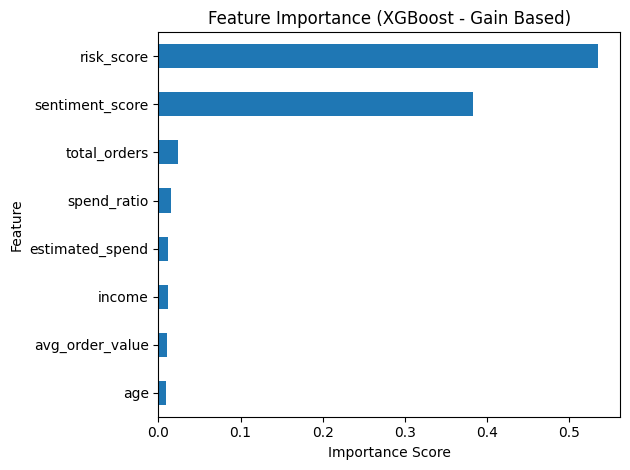

risk_score         0.534924
sentiment_score    0.382772
total_orders       0.024205
spend_ratio        0.015135
estimated_spend    0.011927
income             0.011219
avg_order_value    0.010409
age                0.009408
dtype: float32


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract gain-based feature importance from XGBoost
xgb_importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# Display top 10 features
top10 = xgb_importance.head(10)

# Plot
top10.sort_values().plot(kind="barh")
plt.title("Feature Importance (XGBoost - Gain Based)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print values
print(top10)

## 6. Save Results

In [7]:
results = {
    "model": "XGBoost",
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}

pd.DataFrame([results])


,model,accuracy,f1_score,roc_auc
0,XGBoost,0.945833,0.926554,0.962225


## 7. Documentation

> **XGBoost Model**
>
> An XGBoost classifier was implemented as a gradient-boosted ensemble model to capture complex non-linear relationships within the customer churn dataset. The model demonstrated strong and consistent performance across evaluation metrics, indicating effective learning of higher-order feature interactions.

Interpretation: The model’s balanced Accuracy, F1-score, and ROC-AUC values suggest robust generalization in the presence of injected probabilistic churn noise. Unlike the baseline Decision Tree, XGBoost distributes predictive importance across multiple behavioral and demographic features, reducing over-reliance on any single variable and confirming resistance to data leakage.